# Exploring Dandiset 000690: Visual Cortical Response to Object-like Stimuli in Awake Mice

**Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results, and verify findings independently.

This notebook provides an introduction to DANDI:000690, which contains electrophysiology recordings from mouse visual cortex during presentation of various visual stimuli. The dataset includes spike-sorted unit data, behavioral measurements (running wheel, eye tracking), and detailed stimulus presentation information.

**Dandiset Link:** https://dandiarchive.org/dandiset/000690/0.250326.0015

## Required Packages

The following packages are required to run this notebook:
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `matplotlib`
- `pandas`

## Overview of the Dandiset

Let's start by exploring the basic metadata of this dandiset using the DANDI Python API.

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("000690", "0.250326.0015")

# Get basic metadata
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015


## Exploring NWB Files in the Dandiset

This dandiset contains two main types of NWB files:
- `*_image.nwb` files: Contain spike-sorted units and are the primary source for neural analysis
- Other NWB files: Typically contain LFP data organized by probe

In [2]:
from itertools import islice
import re

# List all NWB files and classify them
nwb_assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Separate image files from others
image_nwb = [a for a in nwb_assets if a.path.endswith('_image.nwb')]
other_nwb = [a for a in nwb_assets if not a.path.endswith('_image.nwb')]

def summarize_files(asset_list, label, n=5):
    """Print summary of NWB files"""
    print(f"First {min(len(asset_list), n)} {label} files:")
    for asset in islice(asset_list, n):
        size_mb = asset.size / 1024**2
        print(f"- {asset.path} ({size_mb:.1f} MB)")
    print(f"Total {label} files: {len(asset_list)}\n")

summarize_files(image_nwb, '*_image.nwb', 7)
summarize_files(other_nwb, 'other NWB', 5)

First 7 *_image.nwb files:
- sub-695762/sub-695762_ses-1317448357_image.nwb (7552.8 MB)
- sub-692072/sub-692072_ses-1298465622_image.nwb (6470.4 MB)
- sub-695435/sub-695435_ses-1309235849_image.nwb (6325.7 MB)
- sub-692077/sub-692077_ses-1300222049_image.nwb (6527.1 MB)
- sub-695763/sub-695763_ses-1317661297_image.nwb (7796.7 MB)
- sub-695764/sub-695764_ses-1311204385_image.nwb (7378.9 MB)
- sub-699321/sub-699321_ses-1312636156_image.nwb (7195.5 MB)
Total *_image.nwb files: 25

First 5 other NWB files:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (1606.2 MB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (1700.1 MB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (1569.8 MB)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (1673.3 MB)
- sub-692077/sub-692077_ses-1300222049.nwb (2335.5 MB)
Total other NWB files: 131



## Loading and Exploring an Example NWB File

We'll examine a representative `*_image.nwb` file to understand the data structure. These files contain the main neural data including spike times, behavioral signals, and stimulus information.

In [3]:
import pynwb
import h5py
import remfile

# Load a representative image NWB file via streaming
asset = next(dandiset.get_assets_by_glob("sub-695762/sub-695762_ses-1317448357_image.nwb"))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Display basic session information
print("=== Session Information ===")
print(f"NWB identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject age (days): {nwb.subject.age_in_days}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject species: {nwb.subject.species}")
print(f"Stimulus notes: {nwb.stimulus_notes}")

print(f"\n=== Data Summary ===")
print(f"Number of units: {len(nwb.units.id[:])}")
print(f"Number of electrodes: {len(nwb.electrodes.id[:])}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


=== Session Information ===
NWB identifier: 1317448357
Session start time: 2023-12-13 00:00:00-08:00
Institution: Allen Institute
Subject ID: 695762
Subject age (days): 141.0
Subject sex: F
Subject species: Mus musculus
Stimulus notes: OpenScopeVision2Hippocampus

=== Data Summary ===
Number of units: 1918
Number of electrodes: 1152


## Neural Data: Spike Sorting Results

The units table contains extensive spike sorting results. Let's examine the distribution of spike counts per unit to understand the dataset's neural activity.

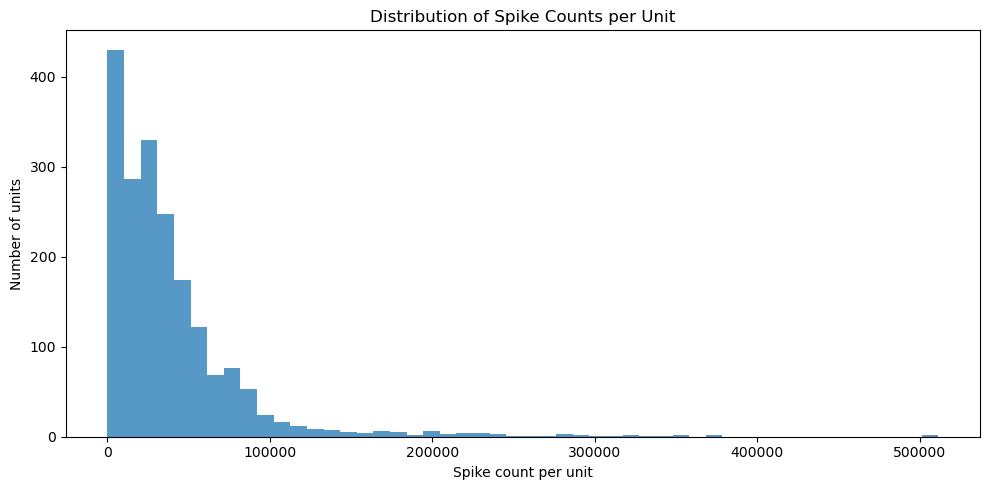

Mean spikes per unit: 39099
Median spikes per unit: 27612
Range: 2 - 511455 spikes


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Extract spike counts for each unit
unit_ids = nwb.units.id[:]
spike_counts = np.array([len(nwb.units.spike_times_index[i]) for i in range(len(unit_ids))])

# Plot distribution of spike counts
plt.figure(figsize=(10, 5))
plt.hist(spike_counts, bins=50, color='tab:blue', alpha=0.75)
plt.xlabel('Spike count per unit')
plt.ylabel('Number of units')
plt.title('Distribution of Spike Counts per Unit')
plt.tight_layout()
plt.show()

print(f"Mean spikes per unit: {np.mean(spike_counts):.0f}")
print(f"Median spikes per unit: {np.median(spike_counts):.0f}")
print(f"Range: {np.min(spike_counts)} - {np.max(spike_counts)} spikes")

## Visual Stimuli

The dataset contains multiple visual stimulus templates. Let's explore the available stimuli and visualize an example frame.

Available stimulus templates (16 total):
1. DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
2. Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
3. Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
4. Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
5. SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
6. SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations
...


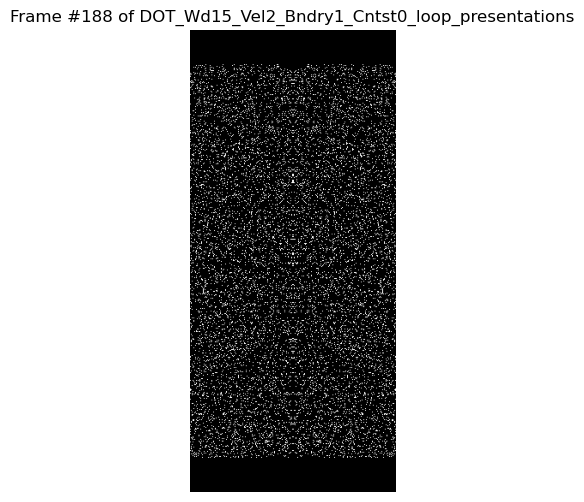

Stimulus shape: (960, 540, 240) (frames, height, width)


In [5]:
# List available stimulus templates
stim_templates = list(nwb.stimulus_template.keys())
print(f"Available stimulus templates ({len(stim_templates)} total):")
for i, name in enumerate(stim_templates[:6]):
    print(f"{i+1}. {name}")
if len(stim_templates) > 6:
    print("...")

# Examine a stimulus template and find a non-black frame
stim_name = stim_templates[0]
stim_data = nwb.stimulus_template[stim_name].data

# Find first non-zero frame
frame_idx = 0
for idx in range(stim_data.shape[0]):
    if np.any(stim_data[idx, :, :] > 0):
        frame_idx = idx
        break

frame = stim_data[frame_idx, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(frame, cmap='gray')
plt.title(f'Frame #{frame_idx} of {stim_name}')
plt.axis('off')
plt.show()

print(f"Stimulus shape: {stim_data.shape} (frames, height, width)")

## Behavioral Data

The dataset includes behavioral monitoring through running wheel signals and eye tracking. Let's visualize these important behavioral correlates.

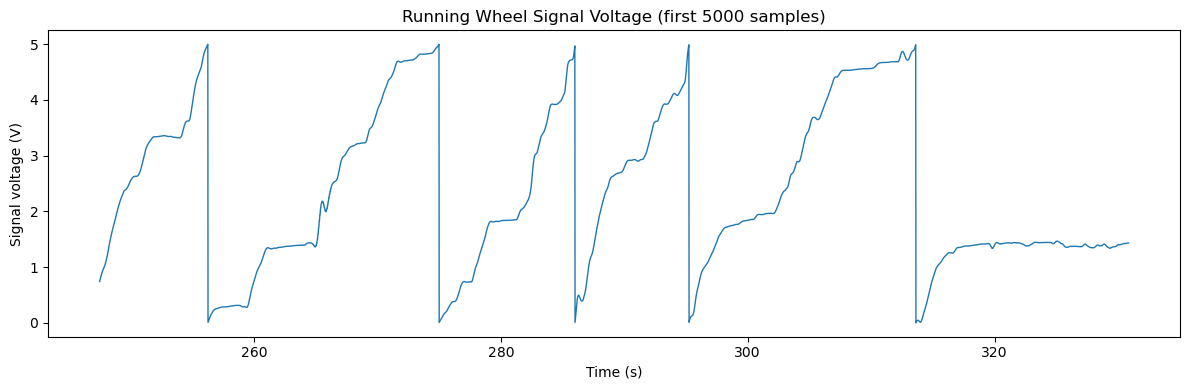

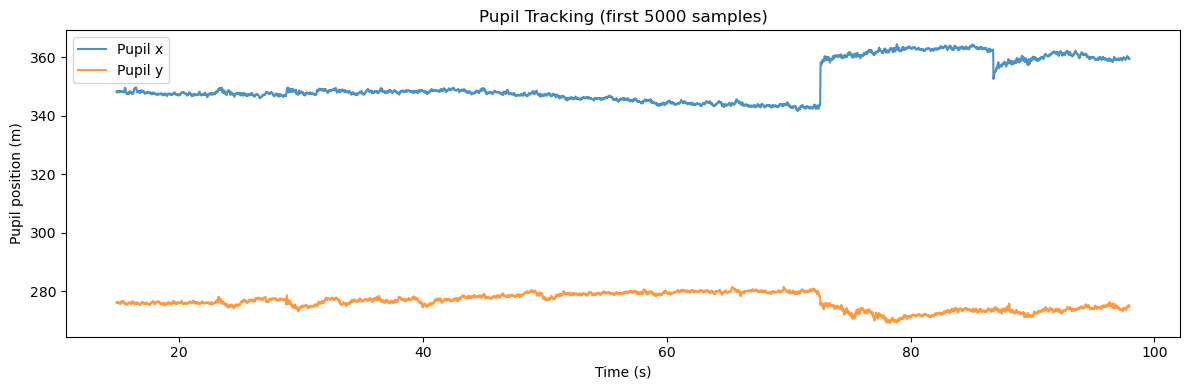

In [6]:
# Running wheel signal
rw_signal = nwb.acquisition['running_wheel_signal_voltage']
rw_data = rw_signal.data[:5000]  # Sample first 5000 points
rw_ts = rw_signal.timestamps[:5000]

plt.figure(figsize=(12, 4))
plt.plot(rw_ts, rw_data, lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Signal voltage (V)')
plt.title('Running Wheel Signal Voltage (first 5000 samples)')
plt.tight_layout()
plt.show()

# Eye tracking data
pupil_tracking = nwb.acquisition['EyeTracking'].pupil_tracking
eyepos = pupil_tracking.data[:5000]
eyets = pupil_tracking.timestamps[:5000]

plt.figure(figsize=(12, 4))
plt.plot(eyets, eyepos[:, 0], label='Pupil x', alpha=0.8)
plt.plot(eyets, eyepos[:, 1], label='Pupil y', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Pupil position (m)')
plt.title('Pupil Tracking (first 5000 samples)')
plt.legend()
plt.tight_layout()
plt.show()

## Stimulus Presentation Intervals

The dataset provides detailed timing and parameter information for each stimulus presentation, enabling precise alignment of neural responses with visual stimuli.

In [7]:
import pandas as pd

# Examine stimulus intervals
interval_names = list(nwb.intervals.keys())
print("Available stimulus intervals:")
for name in interval_names:
    print(f"- {name}")

# Look at details of first stimulus interval
example_interval = interval_names[0]
interval_table = nwb.intervals[example_interval]
interval_df = interval_table.to_dataframe().head(5)

print(f"\nFirst 5 presentations of '{example_interval}':")
print(interval_df[['start_time', 'stop_time', 'frame', 'contrast', 'orientation']].round(3))

Available stimulus intervals:
- DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations
- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations
- SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations
- SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations
- UD_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- acurl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- curl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- invalid_times
- natmovie_20sec_EagleSwoop1_540x960Full_584x460Active_presentations
- natmovie_20sec_SquirrelMice_540x960Full_584x460Active_presentations
- receptive_field_block_presentations



First 5 presentations of 'DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations':
    start_time  stop_time  frame  contrast  orientation
id                                                     
0      985.157    985.174    0.0       1.0          0.0
1      985.174    985.191    1.0       1.0          0.0
2      985.191    985.207    2.0       1.0          0.0
3      985.207    985.224    3.0       1.0          0.0
4      985.224    985.241    4.0       1.0          0.0


## Spike Data Access and Stimulus Alignment

Here we demonstrate how to extract spike times for individual units and align them with stimulus presentations.

In [8]:
# Example: Extract spikes for the first unit
first_unit_id = unit_ids[0]
spike_times = nwb.units.spike_times_index[0]

print(f"Unit {first_unit_id} spike analysis:")
print(f"- Total spikes: {len(spike_times):,}")
print(f"- First 10 spike times: {spike_times[:10]}")

# Align spikes to a stimulus presentation
stim_start = interval_df.iloc[0]["start_time"]
stim_stop = interval_df.iloc[0]["stop_time"]

# Find spikes during this presentation
spikes_in_interval = spike_times[(spike_times >= stim_start) & (spike_times < stim_stop)]

print(f"\nStimulus presentation window: {stim_start:.3f} - {stim_stop:.3f} s")
print(f"Spikes during this presentation: {len(spikes_in_interval)}")

Unit 9 spike analysis:
- Total spikes: 104,526
- First 10 spike times: [20.14667131 20.235471   20.55783655 20.62730298 20.68956943 20.81560233
 21.09126805 21.10580133 21.24293419 21.25903413]

Stimulus presentation window: 985.157 - 985.174 s
Spikes during this presentation: 0


## Summary

This dandiset provides rich multimodal data for investigating visual cortical processing:

**Neural Data:**
- 1,918 spike-sorted units from Neuropixels probes
- High-quality spike sorting with detailed metrics
- Multiple brain regions sampled

**Behavioral Monitoring:**
- Running wheel position and velocity
- Eye tracking (pupil position, area, etc.)
- Blink detection

**Visual Stimulation:**
- 16 different stimulus types
- Detailed frame-by-frame presentation timing
- Parametric stimulus control (contrast, orientation, etc.)

The data structure enables investigations into stimulus-response relationships, behavioral state effects on visual processing, and population dynamics across visual cortical areas. Researchers can build on these examples to perform peristimulus time histogram analyses, decode visual features from neural activity, or study the interaction between behavior and sensory processing.